In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 39s 509ms/step - loss: 0.3060 - root_mean_squared_error: 0.5532 - val_loss: 0.2473 - val_root_mean_squared_error: 0.4973
Epoch 2/50
53/53 [==============================] - 26s 494ms/step - loss: 0.1405 - root_mean_squared_error: 0.3749 - val_loss: 0.0786 - val_root_mean_squared_error: 0.2803
Epoch 3/50
53/53 [==============================] - 25s 471ms/step - loss: 0.0690 - root_mean_squared_error: 0.2627 - val_loss: 0.0629 - val_root_mean_squared_error: 0.2509
Epoch 4/50
53/53 [==============================] - 25s 478ms/step - loss: 0.0543 - root_mean_squared_error: 0.2331 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2180
Epoch 5/50
53/53 [==============================] - 23s 435ms/step - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1835
Epoch 6/50
53/53 [==============================] - 23s 448ms/step - loss: 0.0307 - root_mean_squared_error: 0.1751 - val_loss: 0.0243 

Epoch 32/50
53/53 [==============================] - 3s 56ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 33/50
53/53 [==============================] - 3s 57ms/step - loss: 0.0061 - root_mean_squared_error: 0.0778 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 34/50
53/53 [==============================] - 3s 57ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 35/50
53/53 [==============================] - 3s 58ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653
Epoch 36/50
53/53 [==============================] - 3s 63ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 37/50
53/53 [==============================] - 3s 60ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0049 - val_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

10.755928711096447 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

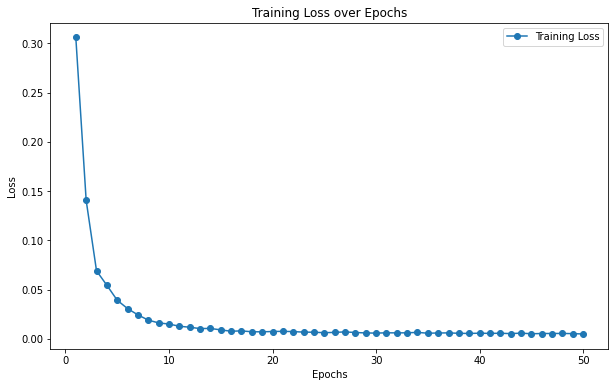

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

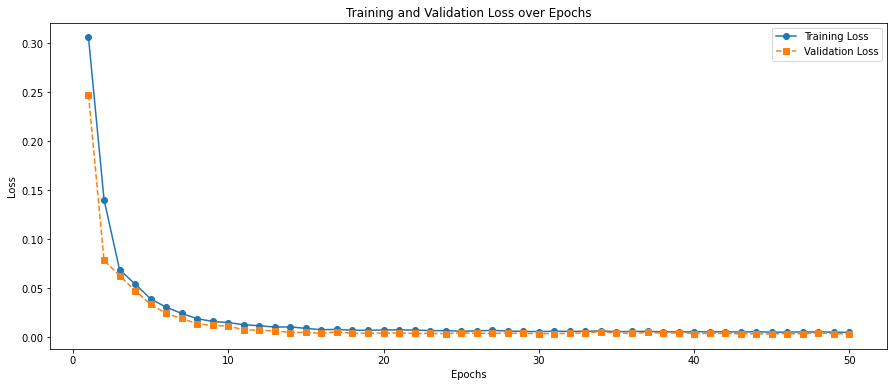

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 22ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0599034791447469
MAE : 0.04853420946124659


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,4.176743e+06,3498103.449
1,2.275899e+06,1633675.726
2,1.152623e+06,1292668.399
3,1.359346e+06,1527666.815
4,2.395953e+06,2121949.701
5,3.599318e+06,3562381.775
6,4.772031e+06,5004305.983
7,5.751860e+06,6176613.878
8,6.331750e+06,6794233.093
9,6.525203e+06,7024136.637


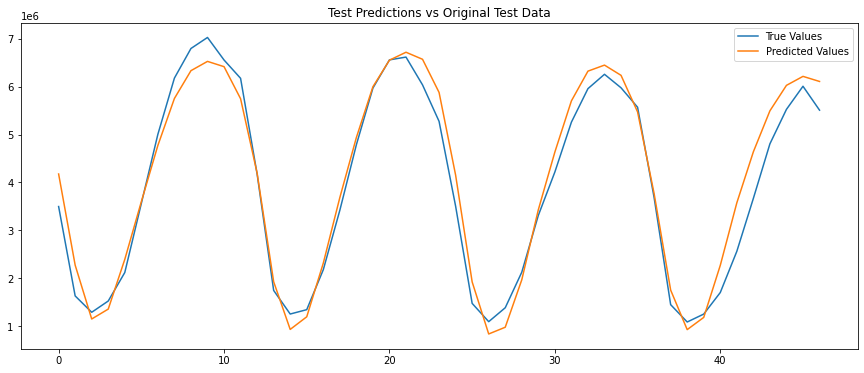

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 34ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

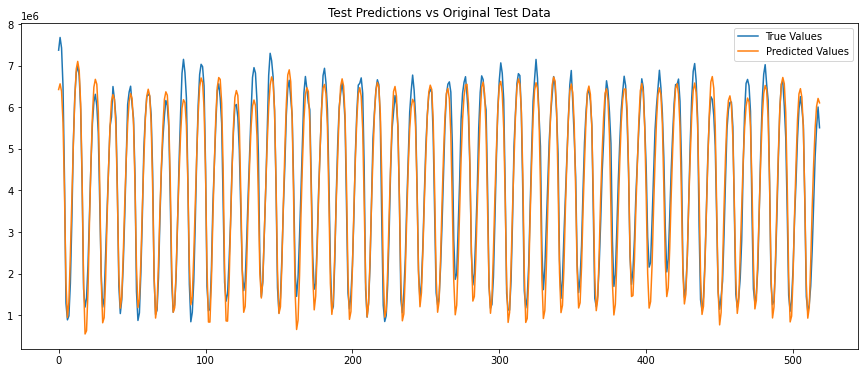

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()